



In this tutorial, we will download, combine and visualize all 14 tiles of MODIS land surface tempreture that covers Contiguous United States (CONUS).




Developed by Keyhan Gavahi, March 2024.


**1. Import Libraries**

In [ ]:
import pandas as pd
import urllib.request
from bs4 import BeautifulSoup
import os
from pyhdf.SD import SD, SDC
import numpy as np
import pandas as pd
import re
from pyproj import Transformer
import xarray as xr
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

**2. Download Data**

The first step would be to download the data. I developed the following class which will help us to easily do that. You can use this for any MODIS product (here is the full list for [terra](https://e4ftl01.cr.usgs.gov/MOLT/) and [aqua](https://e4ftl01.cr.usgs.gov/MOLA/)). To be able to use it, you will need wget and a NASA EARTHDATA account. You can easily create one [here](https://https://urs.earthdata.nasa.gov/).  Let’s start working with MOD11A2 Version 6.1 product which provides an average 8-day per-pixel Land Surface Temperature. We will download all the MOD11A2 version 6.1 files that cover Contiguous United States (CONUS) for the January 1st, 2021.

In [ ]:
class DataPreprocess:


    def __init__(self, user=None, password=None):


        self.user = user
        self.password = password





    def dl_modis(self, path=None, product=None,
                 start_date=None, end_date=None, tiles=None):

        #assert isinstance(tiles, list), 'tiles must be a list'

        if tiles=='conus':
            # 14 tiles that cover the CONUS
            tiles = ["h08v04","h08v05","h08v06",
                            "h09v04","h09v05","h09v06",
                             "h10v04","h10v05","h10v06",
                             "h11v04","h11v05","h12v04",
                             "h12v05","h13v04"]

        satellite_mapping = {
            'MCD': 'MOTA',
            'MYD': 'MOLA',
            'MOD': 'MOLT'
        }

        satellite = satellite_mapping.get(product[:3], 'unknown')

        if end_date==None:
            date_range = pd.date_range(start=start_date,
                                       end=start_date,
                                       freq='D')
        else:
            date_range = pd.date_range(start=start_date,
                                       end=end_date,
                                       freq='D')

        date_str = [str(date)[:10].replace('-', '') for date in date_range]

        page_url = f'https://e4ftl01.cr.usgs.gov/{satellite}/{product}/'

        uf = urllib.request.urlopen(page_url, timeout=120)
        html = uf.read()
        soup = BeautifulSoup(html, "html.parser")
        link_list = set([link.get('href') for link in soup.find_all('a')])

        filtered_links = [link for link in link_list if
                          any(date in link.replace('.', '') for date in date_str)]

        page_urls = [page_url+link for link in filtered_links]


        urls = []
        for page_url in page_urls:

            uf = urllib.request.urlopen(page_url, timeout=120)
            html = uf.read()
            soup = BeautifulSoup(html, "html.parser")
            link_list = set([link.get('href') for link in soup.find_all('a')])

            filtered_links = [link for link in link_list if
                              any(tile in link for tile in tiles)]

            for link in filtered_links:
                urls.append(page_url+link)

        urls = set(urls)
        urls = sorted(urls)

        # let's save the urls in a text file to
        # download them with a single wget command
        txt_path = os.path.join(path, "urls.txt")
        if os.path.exists(txt_path): os.remove(txt_path)

        with open(txt_path, 'a') as fp:
            fp.write('\n'.join(urls))

        # download the files
        os.system(f'wget --load-cookies .urs_cookies --save-cookies \
                  .urs_cookies --keep-session-cookies --user={self.user}\
                      --password={self.password} -P {path}\
                          --content-disposition -i {txt_path}')






In [ ]:
dp = DataPreprocess(user='<YOUR_USERNAME>', password='<YOUR_PASSWORD>')
dp.dl_modis(path='/content', product='MOD11A2.061',
            start_date='20210101',
            tiles='conus')

/content


Now all the 14 tiles that cover CONUS are downloaded and saved in the “content” directory. Let’s have a look at the files inside “content” directory.

In [ ]:
print(os.listdir('/content'))

['.config', '.urs_cookies', 'MOD11A2.A2021001.h11v04.061.2021040211301.hdf', 'MOD11A2.A2021001.h08v06.061.2021040211257.hdf', 'BROWSE.MOD11A2.A2021001.h10v04.061.2021040161300.2.jpg', 'BROWSE.MOD11A2.A2021001.h11v04.061.2021040161304.1.jpg', 'MOD11A2.A2021001.h08v04.061.2021040211315.hdf.xml', 'BROWSE.MOD11A2.A2021001.h09v04.061.2021040161307.1.jpg', 'BROWSE.MOD11A2.A2021001.h12v05.061.2021040161256.1.jpg', 'BROWSE.MOD11A2.A2021001.h10v04.061.2021040161300.1.jpg', 'MOD11A2.A2021001.h10v05.061.2021040211258.hdf', 'MOD11A2.A2021001.h10v04.061.2021040211259.hdf.xml', 'MOD11A2.A2021001.h09v06.061.2021040211315.hdf.xml', 'MOD11A2.A2021001.h09v05.061.2021040211302.hdf.xml', 'MOD11A2.A2021001.h08v06.061.2021040211257.hdf.xml', 'MOD11A2.A2021001.h10v06.061.2021040211301.hdf.xml', 'urls.txt', 'MOD11A2.A2021001.h09v04.061.2021040211306.hdf.xml', 'MOD11A2.A2021001.h08v05.061.2021040211302.hdf', 'BROWSE.MOD11A2.A2021001.h10v05.061.2021040161301.1.jpg', 'BROWSE.MOD11A2.A2021001.h12v04.061.202104016

We can see that all the files related to MOD11A2 version 6.1 for 20210101 date are now in this directory. But we only need the hdf files so let’s filter them:

In [ ]:
import glob
files = glob.glob('/content/*.hdf')
for file in files:
  print(file)

/content/MOD11A2.A2021001.h11v04.061.2021040211301.hdf
/content/MOD11A2.A2021001.h08v06.061.2021040211257.hdf
/content/MOD11A2.A2021001.h10v05.061.2021040211258.hdf
/content/MOD11A2.A2021001.h08v05.061.2021040211302.hdf
/content/MOD11A2.A2021001.h10v04.061.2021040211259.hdf
/content/MOD11A2.A2021001.h09v06.061.2021040211315.hdf
/content/MOD11A2.A2021001.h13v04.061.2021040211253.hdf
/content/MOD11A2.A2021001.h12v04.061.2021040211254.hdf
/content/MOD11A2.A2021001.h09v05.061.2021040211302.hdf
/content/MOD11A2.A2021001.h10v06.061.2021040211301.hdf
/content/MOD11A2.A2021001.h08v04.061.2021040211315.hdf
/content/MOD11A2.A2021001.h12v05.061.2021040211254.hdf
/content/MOD11A2.A2021001.h11v05.061.2021040211257.hdf
/content/MOD11A2.A2021001.h09v04.061.2021040211306.hdf


**3. Get Coordinates**

As I mentioned MODIS does not provide x and y coordinates for all the pixels. However, the hdf files contain the corner coordinates. We can use those and the number of rows and columns in the raster image to create the x and y coordinates. The following function will do that for us.

In [ ]:
def mod_y_x(hdf):

    gridmeta = hdf.attributes(full=1)["StructMetadata.0"][0]

    ul_regex = re.compile(r'''UpperLeftPointMtrs=\(
                              (?P<upper_left_x>[+-]?\d+\.\d+)
                              ,
                              (?P<upper_left_y>[+-]?\d+\.\d+)
                              \)''', re.VERBOSE)

    match = ul_regex.search(gridmeta)
    x0 = float(match.group('upper_left_x'))
    y0 = float(match.group('upper_left_y'))

    lr_regex = re.compile(r'''LowerRightMtrs=\(
                              (?P<lower_right_x>[+-]?\d+\.\d+)
                              ,
                              (?P<lower_right_y>[+-]?\d+\.\d+)
                              \)''', re.VERBOSE)
    match = lr_regex.search(gridmeta)
    x1 = float(match.group('lower_right_x'))
    y1 = float(match.group('lower_right_y'))

    nx, ny = data[0].shape
    x = np.linspace(x0, x1, nx*2+1)
    y = np.linspace(y0, y1, ny*2+1)

    x = x[1::2]
    y = y[1::2]



    return y, x

**4. Read and Combine hdf Files**

Next, we will read all the hdf files and save them in a dataArray to be able to use Xarray and combine them.

In [ ]:


dss = []

for file in files:
  hdf = SD(file, SDC.READ)
  DATAFIELD_NAME = 'LST_Day_1km'

  # get the dataset fill value
  _FillValue = hdf.select(DATAFIELD_NAME).getfillvalue()

  #get the dataset min and max values: valid_range
  range = hdf.select(DATAFIELD_NAME).getrange()

  # get the dataset calibration coefficients scale_factor, scale_factor_err, add_offset, add_offset_err, calibrated_nt
  cal_coef = hdf.select(DATAFIELD_NAME).getcal()

  # Read dataset
  data2D = hdf.select(DATAFIELD_NAME)
  data = data2D[:,:].astype('float32')
  data = data.reshape(1, data.shape[0], data.shape[1])
  data = np.where((data==_FillValue) | (data < range[0]) | (data > range[1]),
                  np.nan, data) * cal_coef[0]

  # get coordinates
  lat, lon = mod_y_x(hdf)

  da = xr.DataArray(
      data=data,
      dims=["time", "y", "x"],
      coords=dict(
          x=(["x"], lon),
          y=(["y"], lat),
          time=pd.date_range("2021-01-01", periods=1),

      ),

  )

  dss.append(da)

You can also open the hdf files using Xarray and its “netcdf4” engine, however you might end up getting compatibility errors if you don’t have the correct version of Xarray. That’s why we used pyhdf and defined the dataArrays ourself in the for loop.

Now that we have all the 14 tiles as dataArrays saved in the dss list, we can used “combine_by_coords” to merge them.

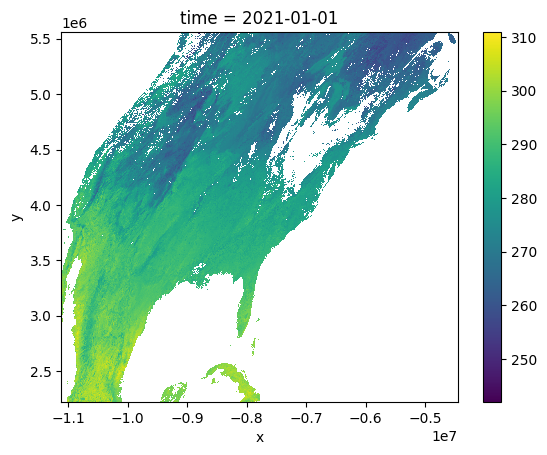

In [ ]:
da_comb = xr.combine_by_coords(dss)
da_comb.plot()

**5. Transform and Visualize**

Next, we will transform the coordinate system from Sinusoidal to WGS84 using the pyproj package.



In [ ]:
xv, yv = np.meshgrid(da_comb.x, da_comb.y)
transformer = Transformer.from_crs("+proj=sinu +R=6371007.181 +nadgrids=@null +wktext",
                                   "+init=EPSG:4326")

x, y= transformer.transform(xv, yv)
print(xv.shape)
print(yv.shape)

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


(3600, 7200)
(3600, 7200)


Finally, let’s plot the combined hdf files using basemap and with a lambert conic projection.

(3600, 7200)


<ipython-input-14-657b6168a38c>:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcolormesh = m.pcolormesh(x, y, da_comb[0], latlon=True, cmap='terrain_r')


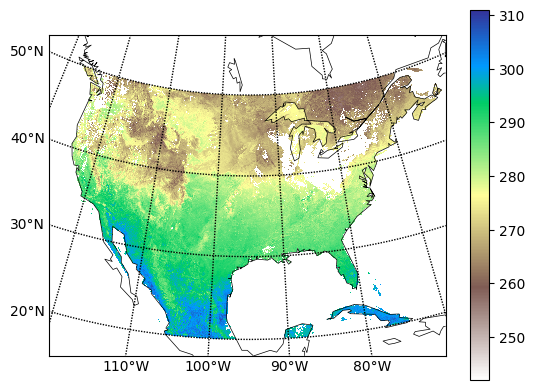

In [ ]:
down = 10
up = 55
left = -130
right = -60
#m = Basemap(projection='cyl', resolution='l',
#            llcrnrlat=down-.1, urcrnrlat =up+.1,
#            llcrnrlon=left-.1, urcrnrlon =right+.1)

m = Basemap(llcrnrlon=-119,llcrnrlat=15,urcrnrlon=-55,urcrnrlat=52,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)


m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(down, up, 10),
                labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(left, right, 10),
                labels=[0, 0, 0, 1])

pcolormesh = m.pcolormesh(x, y, da_comb[0], latlon=True, cmap='terrain_r')
fig = plt.gcf()

fig.colorbar(pcolormesh)